In [1]:
import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

# 设置绘图风格|
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("husl")

plt.rcParams.update(
    {
        "svg.fonttype": "none",
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans", "Helvetica"],
        "font.size": 11,
        "axes.labelsize": 12,
        "axes.titlesize": 13,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.1,
    }
)

In [2]:
# 加载数据 
data = torch.load("../cache/attention_cache_figure4.pt", map_location="cpu", weights_only=False)
# data = torch.load("../cache/attention_cache_wan_base.pt", map_location="cpu", weights_only=False)
print("=" * 70)
print("加载注意力数据")
print("=" * 70)
print(f'Prompt: {data.get("prompt", "N/A")}')
print(f'总帧数: {data.get("num_frames", "N/A")}')
print(f'每帧 token 数: {data.get("frame_seq_length", "N/A")}')
print(f'Query 帧: {data.get("query_frames", "N/A")}')
print(f'Key 帧: {data.get("key_frames", "N/A")}')

attention_weights = data["attention_weights"]
frame_seq_length = data.get("frame_seq_length", 1560)

print()
for i, w in enumerate(attention_weights):
    layer_idx = w["layer_idx"]
    attn = w["attn_logits"]
    num_key_frames = w.get("num_key_frames", attn.shape[3] // frame_seq_length)
    print(f"Layer {layer_idx}: shape={tuple(attn.shape)}, {num_key_frames} key frames")
    print(
        f"  Range: [{attn.float().min().item():.4f}, {attn.float().max().item():.4f}]"
    )

加载注意力数据
Prompt: A majestic eagle soaring through a cloudy sky, cinematic lighting
总帧数: 21
每帧 token 数: 1560
Query 帧: [18, 19, 20]
Key 帧: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

Layer 0: shape=(1, 12, 4680, 32760), 21 key frames
  Range: [-14.3125, 23.7500]
Layer 4: shape=(1, 12, 4680, 32760), 21 key frames
  Range: [-31.2500, 48.5000]


In [3]:
# 计算帧间注意力分布
def compute_frame_attention(attn_data, frame_seq_length=1560):
    attn = attn_data["attn_logits"][0].float().numpy()  # [num_heads, Lq, Lk]
    num_heads, lq, lk = attn.shape
    fsl = attn_data.get("frame_seq_length", frame_seq_length)
    num_key_frames = lk // fsl

    frame_attention = np.zeros((num_heads, num_key_frames))
    for h in range(num_heads):
        head_attn = attn[h]  # [Lq, Lk]
        avg_per_key = head_attn.mean(axis=0)  # [Lk]
        for kf in range(num_key_frames):
            k_start = kf * fsl
            k_end = (kf + 1) * fsl
            frame_attention[h, kf] = avg_per_key[k_start:k_end].mean()

    return frame_attention, np.arange(num_key_frames)

In [4]:
# 处理数据
layer_attention_data = {}
for w in attention_weights:
    layer_idx = w["layer_idx"]
    frame_attn, key_indices = compute_frame_attention(w, frame_seq_length)
    layer_attention_data[layer_idx] = {
        "frame_attention": frame_attn,
        "key_frame_indices": key_indices,
        "num_heads": frame_attn.shape[0],
    }
    print(
        f"Layer {layer_idx}: {len(key_indices)} key frames, {frame_attn.shape[0]} heads"
    )

    # 打印帧间差异
    for h in [0, frame_attn.shape[0] - 1]:
        head = frame_attn[h]
        diff = (head.max() - head.min()) / np.abs(head.mean()) * 100
        print(
            f"  Head {h+1}: first={head[0]:.4f}, last={head[-1]:.4f}, diff={diff:.1f}%"
        )

Layer 0: 21 key frames, 12 heads
  Head 1: first=-0.2672, last=2.2365, diff=3740.1%
  Head 12: first=2.7008, last=5.6666, diff=765.6%
Layer 4: 21 key frames, 12 heads
  Head 1: first=2.4994, last=3.1915, diff=189.6%
  Head 12: first=3.5837, last=6.6134, diff=136.8%


绘制 Figure 4: 帧间注意力分布
已保存: figure4_reproduction.svg


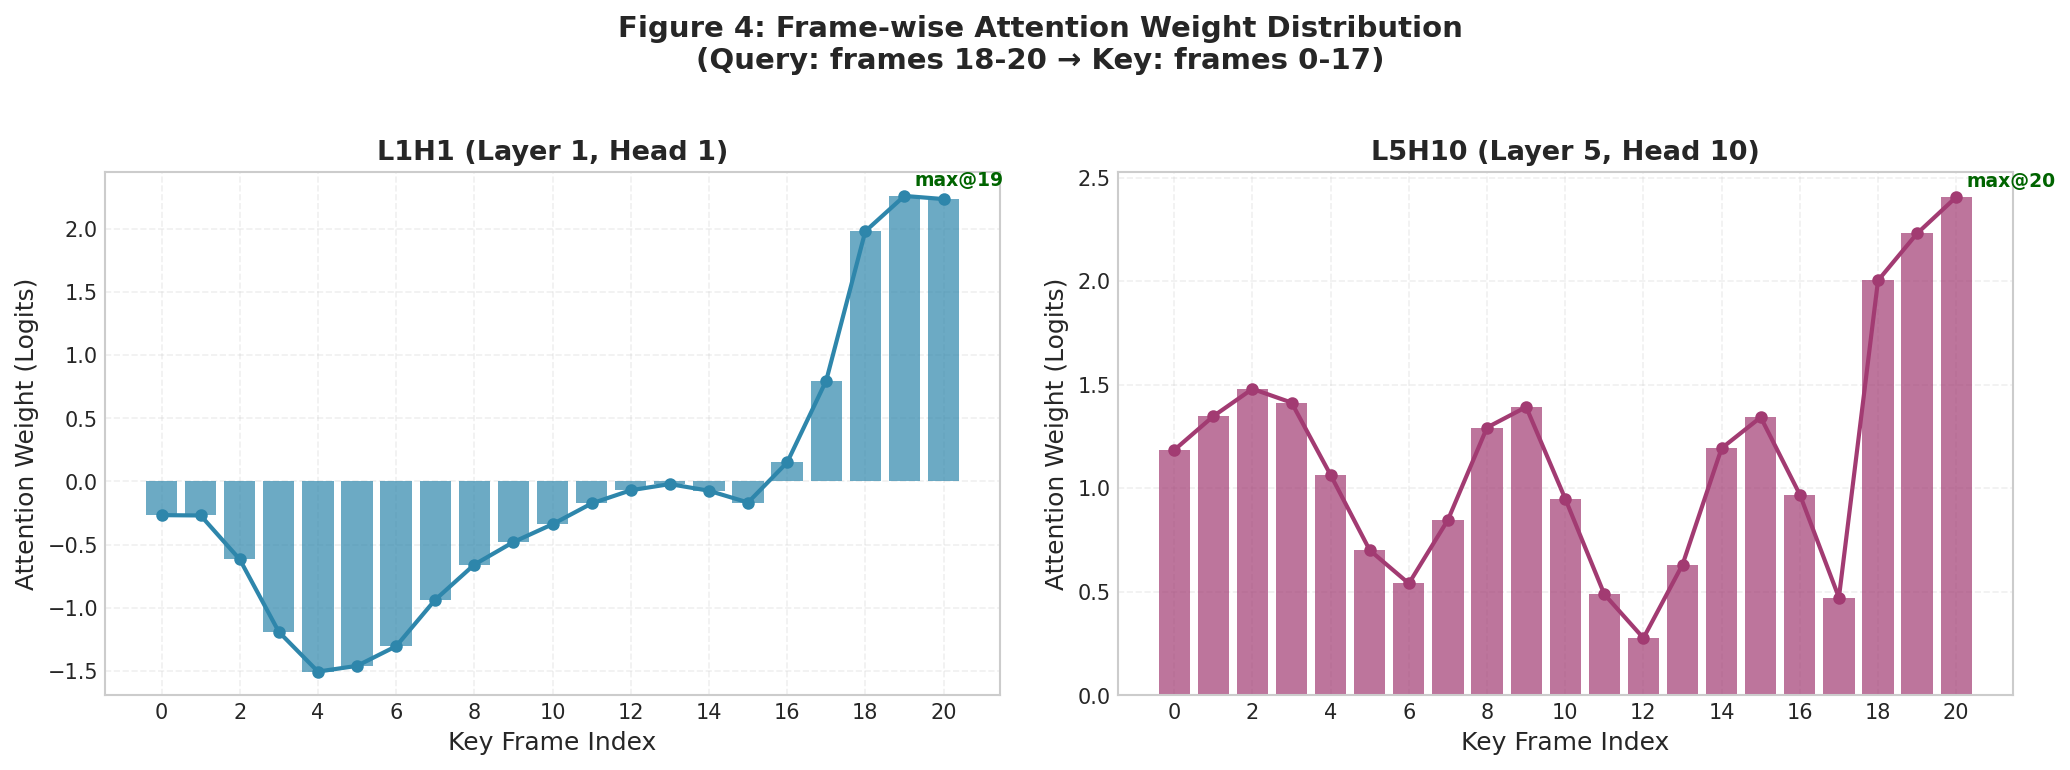

In [5]:
# ===== 绘制 Figure 4 =====
print("=" * 70)
print("绘制 Figure 4: 帧间注意力分布")
print("=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = ["#2E86AB", "#A23B72"]

heads_to_show = [
    (0, 0, "L1H1"),  # Layer 1, Head 1
    (4, 9, "L5H10"),  # Layer 5, Head 10
]

for idx, (layer_idx, head_idx, label) in enumerate(heads_to_show):
    ax = axes[idx]
    if layer_idx not in layer_attention_data:
        continue

    frame_attn = layer_attention_data[layer_idx]["frame_attention"][head_idx]
    key_indices = layer_attention_data[layer_idx]["key_frame_indices"]
    color = colors[idx]

    # 柱状图 + 折线图
    ax.bar(key_indices, frame_attn, color=color, alpha=0.7, width=0.8)
    ax.plot(key_indices, frame_attn, "o-", color=color, linewidth=2, markersize=5)

    ax.set_xlabel("Key Frame Index", fontsize=12)
    ax.set_ylabel("Attention Weight (Logits)", fontsize=12)
    ax.set_title(
        f"{label} (Layer {layer_idx+1}, Head {head_idx+1})",
        fontsize=13,
        fontweight="bold",
    )
    ax.grid(True, alpha=0.3, linestyle="--")

    # X 轴刻度
    if len(key_indices) <= 20:
        ax.set_xticks(key_indices)
    else:
        ax.set_xticks(key_indices[::2])

    # 标注
    max_idx = np.argmax(frame_attn)
    min_idx = np.argmin(frame_attn)
    ax.annotate(
        f"max@{key_indices[max_idx]}",
        xy=(key_indices[max_idx], frame_attn[max_idx]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=9,
        color="darkgreen",
        fontweight="bold",
    )

plt.suptitle(
    "Figure 4: Frame-wise Attention Weight Distribution\n(Query: frames 18-20 → Key: frames 0-17)",
    fontsize=14,
    fontweight="bold",
    y=1.02,
)
plt.tight_layout()
plt.savefig("figure4_reproduction.svg", format="svg", bbox_inches="tight")
print("已保存: figure4_reproduction.svg")
plt.show()

已保存: figure4_layer1_per_head_grid.svg


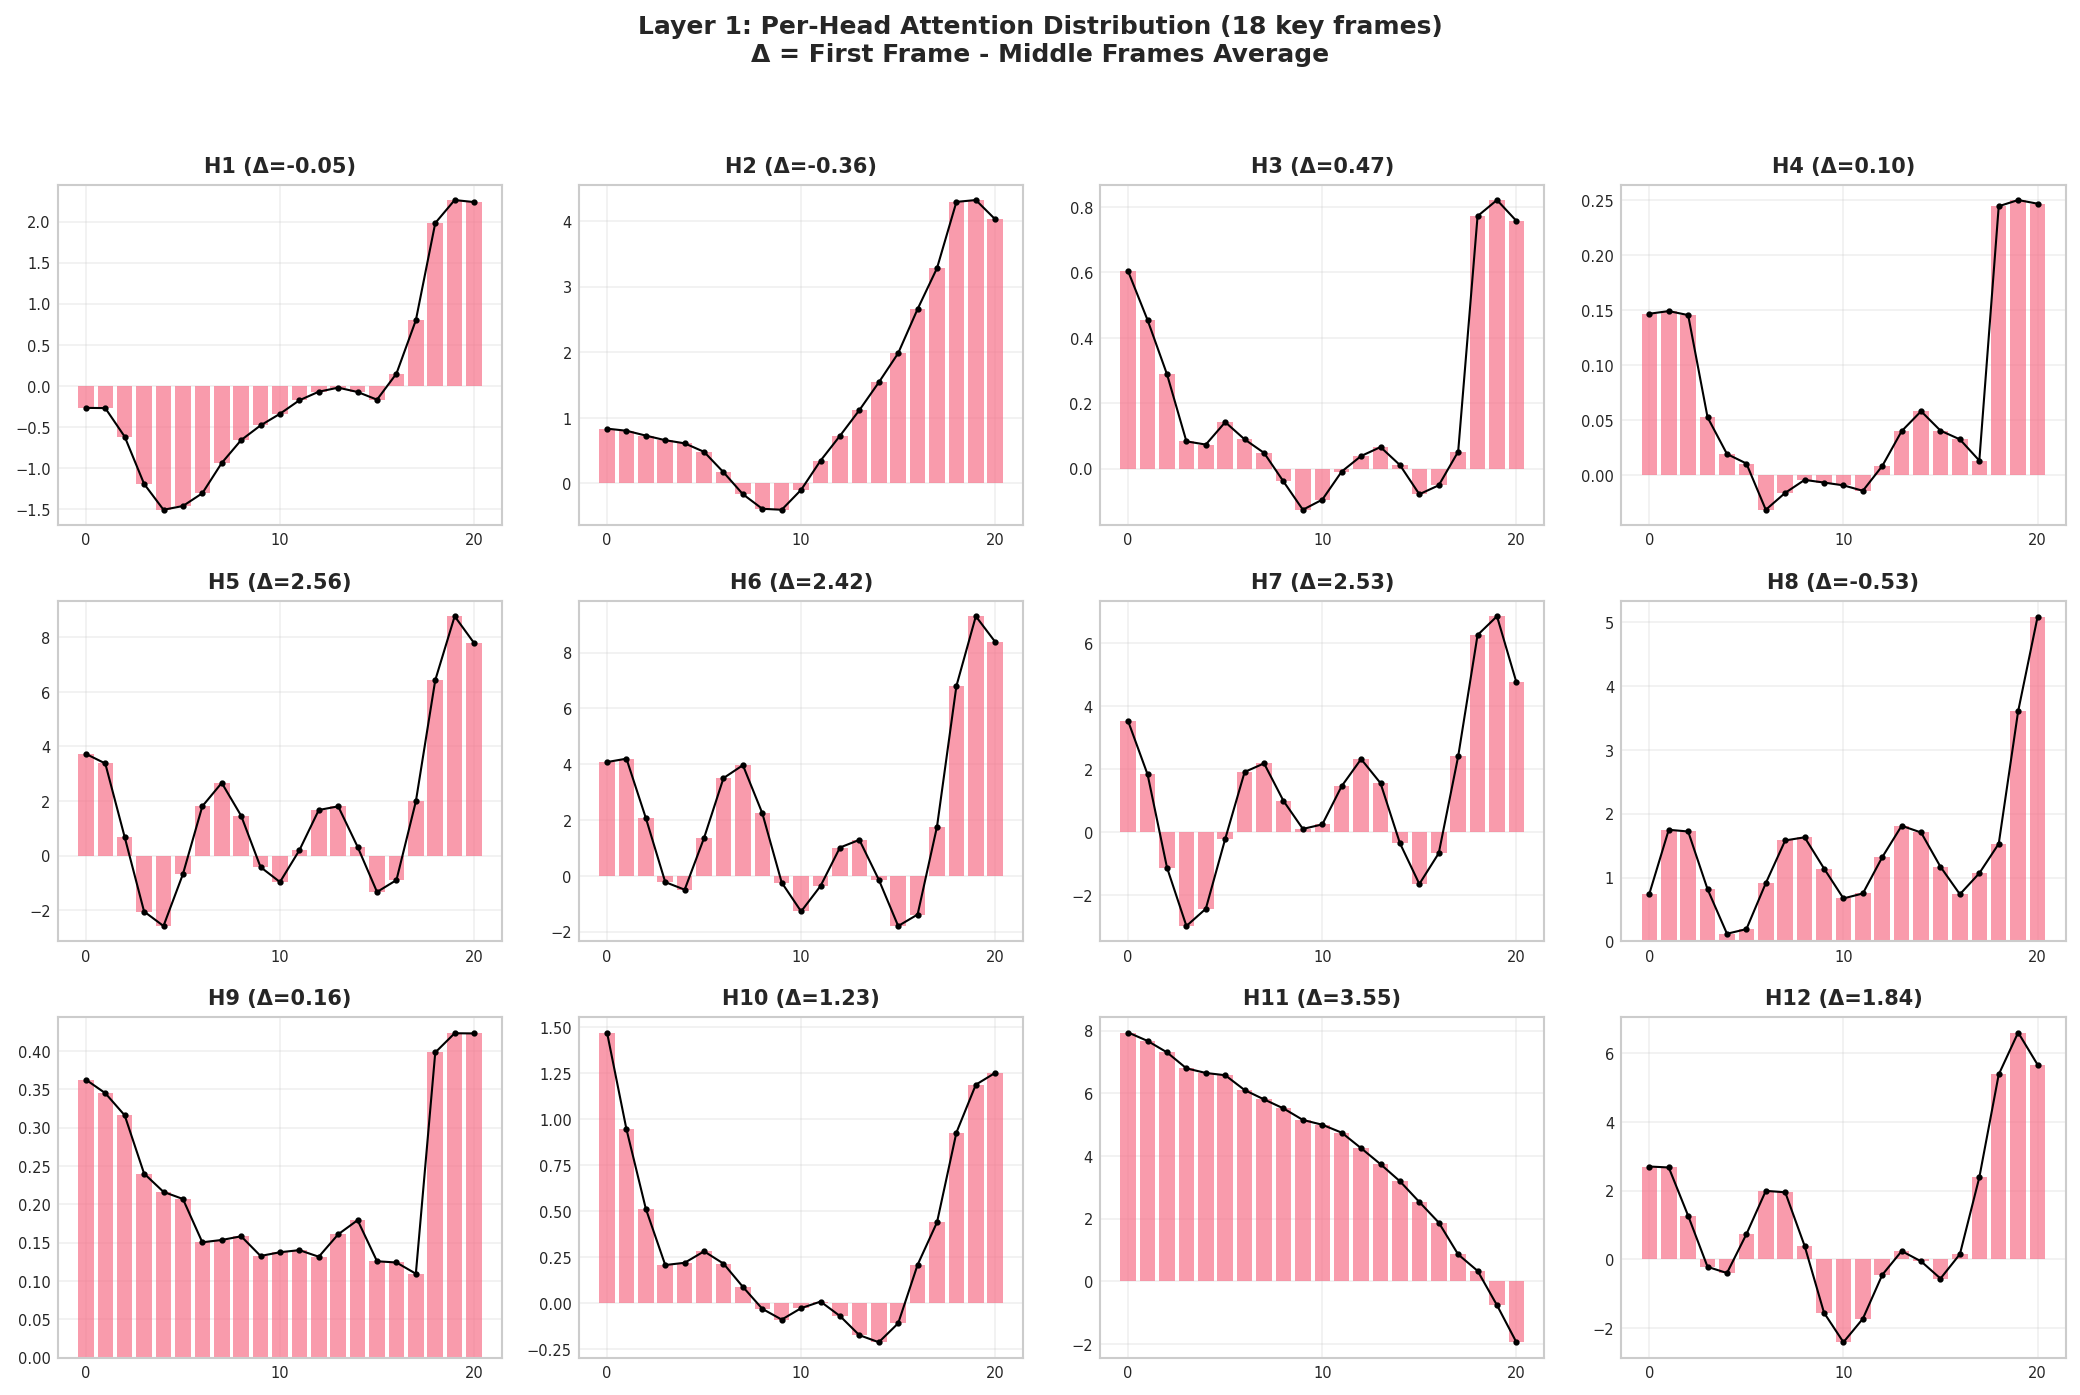

已保存: figure4_layer5_per_head_grid.svg


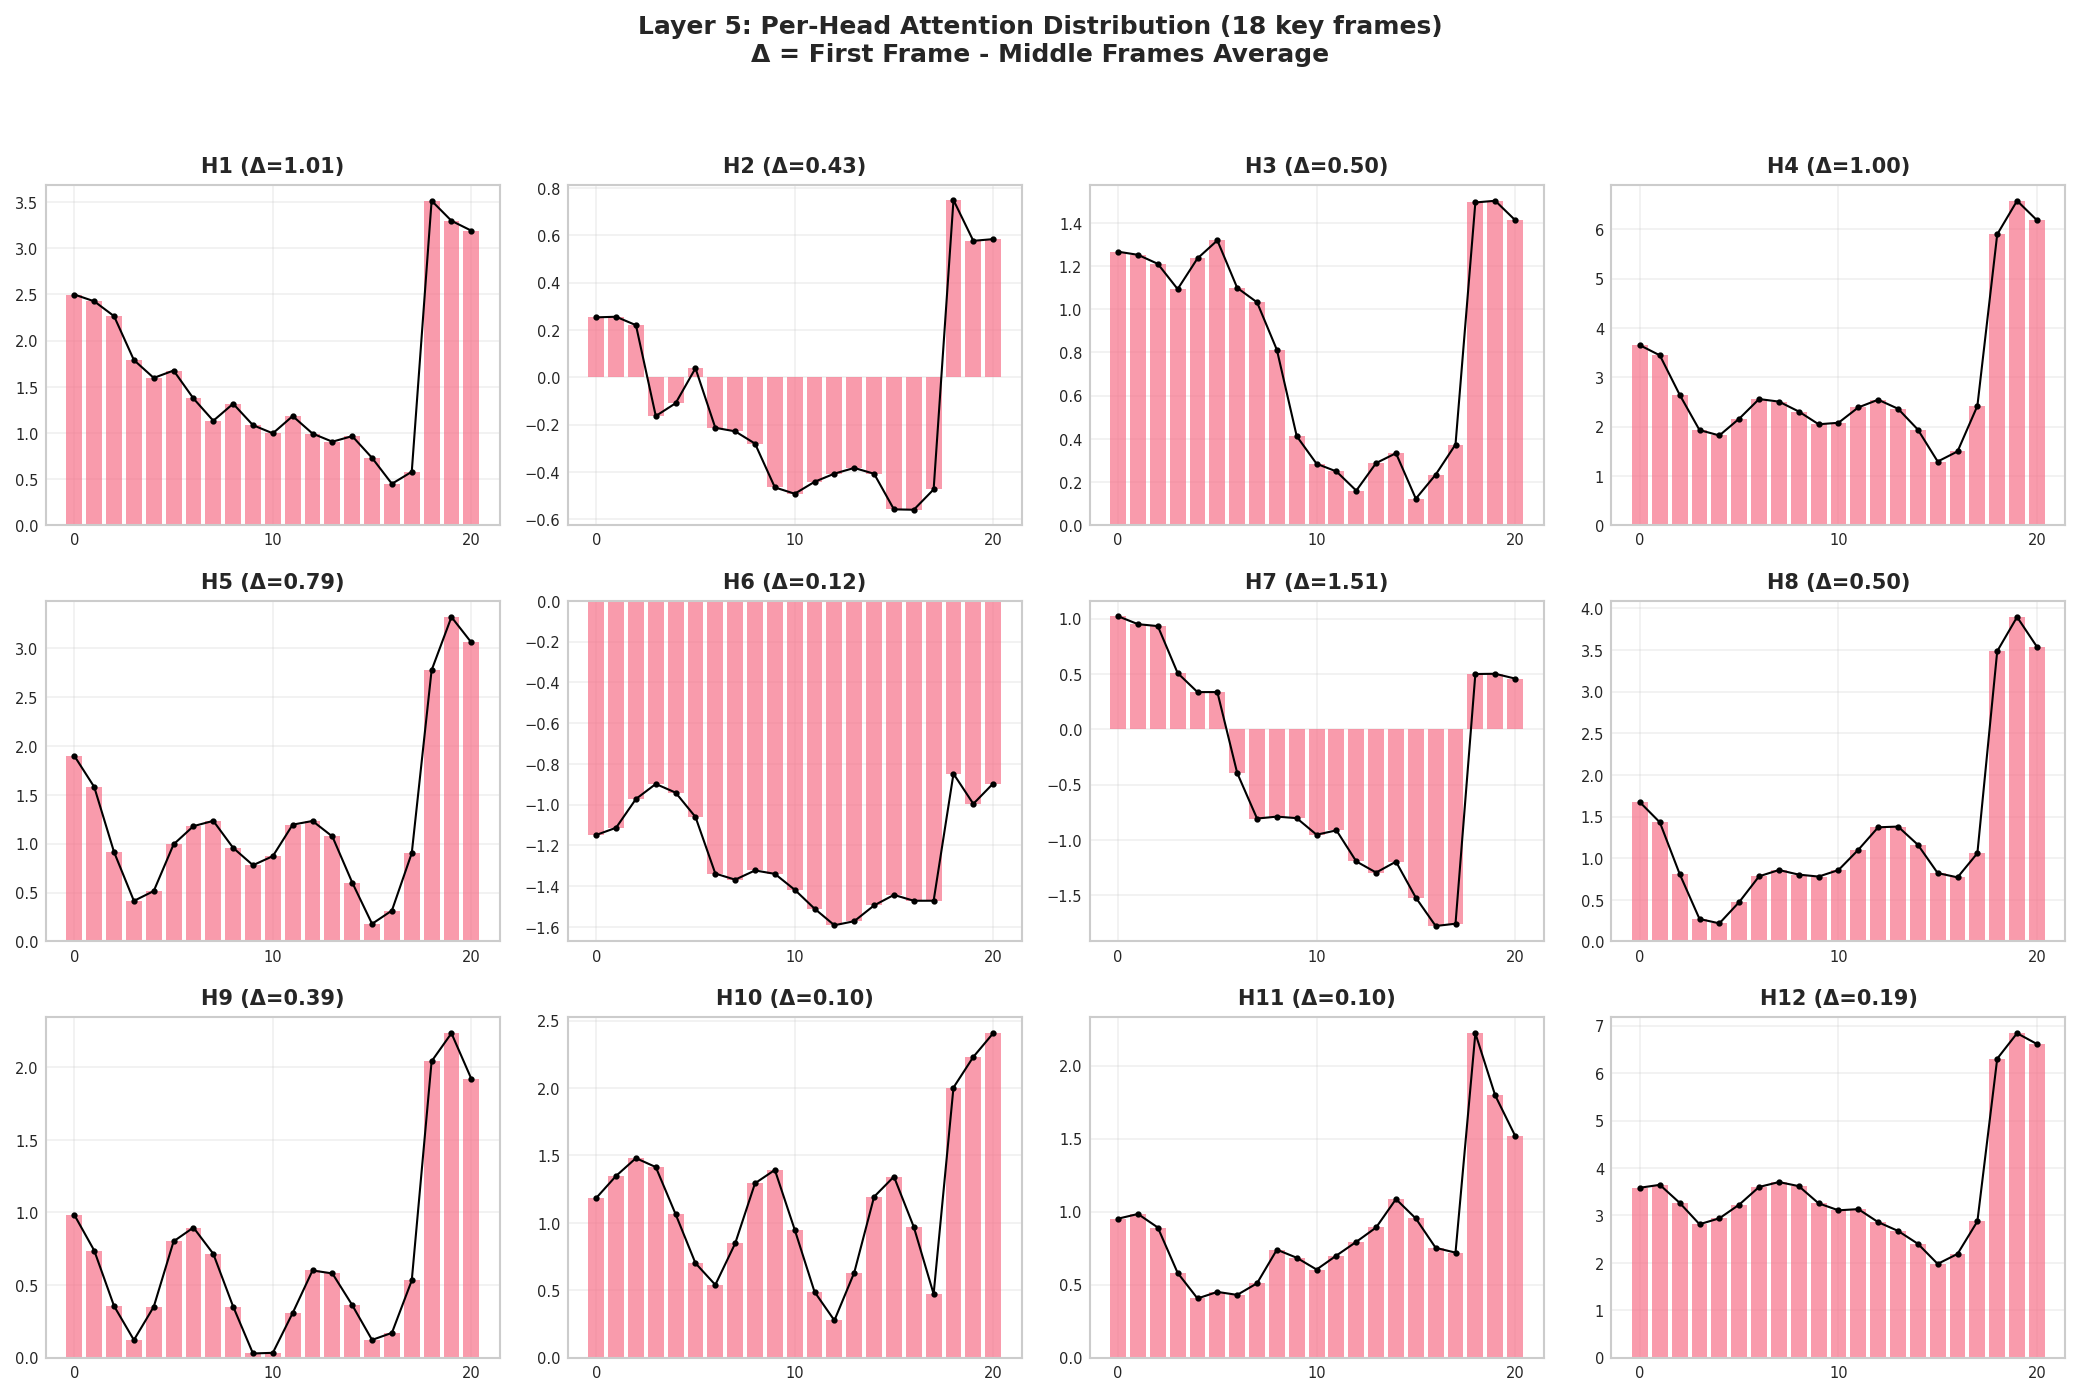

In [6]:
# ===== 绘制 Per-Head Grid =====
for layer_idx in [0, 4]:
    if layer_idx not in layer_attention_data:
        continue

    frame_attn = layer_attention_data[layer_idx]["frame_attention"]
    key_indices = layer_attention_data[layer_idx]["key_frame_indices"]
    num_heads = frame_attn.shape[0]

    # --- 修正 1: 动态计算行数，防止 Head 数量 > 12 时报错 ---
    ncols = 4
    nrows = math.ceil(num_heads / ncols)  # 自动计算需要的行数

    # 调整画布高度，根据行数变化
    fig, axes = plt.subplots(nrows, ncols, figsize=(14, 3 * nrows))
    axes = axes.flatten()

    for h in range(num_heads):
        ax = axes[h]
        head = frame_attn[h]

        # 计算 sink score
        # 注意：这里假设 head 的长度和 key_indices 长度一致
        if len(head) > 0:
            first = head[0]
            middle_vals = head[1:-1]
            middle = middle_vals.mean() if len(middle_vals) > 0 else head.mean()
            sink_score = first - middle
        else:
            sink_score = 0.0

        ax.bar(key_indices, head, alpha=0.7, width=0.8)
        ax.plot(key_indices, head, "o-", color="black", linewidth=1, markersize=2)
        ax.set_title(f"H{h+1} (Δ={sink_score:.2f})", fontsize=10, fontweight="bold")
        ax.tick_params(axis="both", which="major", labelsize=7)
        ax.grid(True, alpha=0.3)

        if len(key_indices) > 10:
            ax.set_xticks([0, len(key_indices) // 2, len(key_indices) - 1])

    for k in range(num_heads, len(axes)):
        axes[k].axis("off")
    title_str = (
        f"Layer {layer_idx+1}: Per-Head Attention Distribution (18 key frames)\n"
        f"Δ = First Frame - Middle Frames Average"
    )

    fig.suptitle(
        title_str, fontsize=12, fontweight="bold", y=1.00 + (0.01 * nrows)
    )

    plt.tight_layout()
    plt.savefig(
        f"figure4_layer{layer_idx+1}_per_head_grid.svg",
        format="svg",
        bbox_inches="tight",
    )
    print(f"已保存: figure4_layer{layer_idx+1}_per_head_grid.svg")

    plt.show()

已保存: figure4_layer1_all_heads.svg


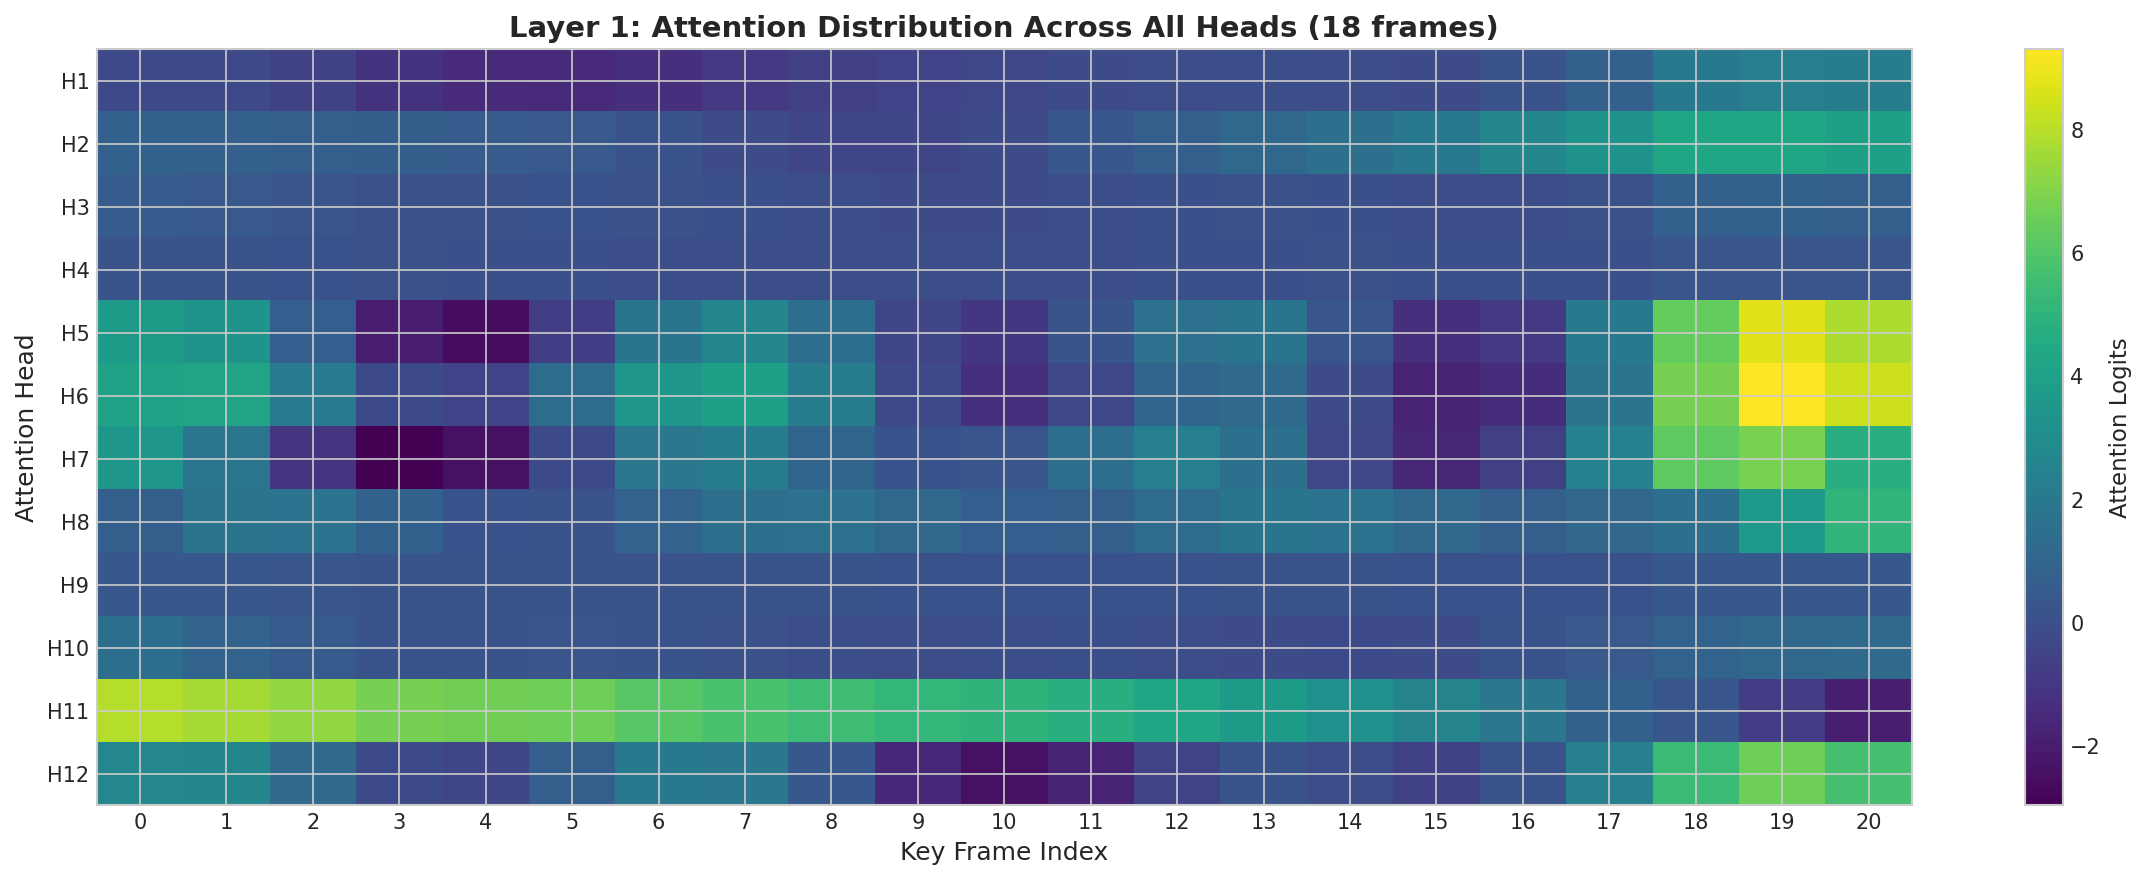

已保存: figure4_layer5_all_heads.svg


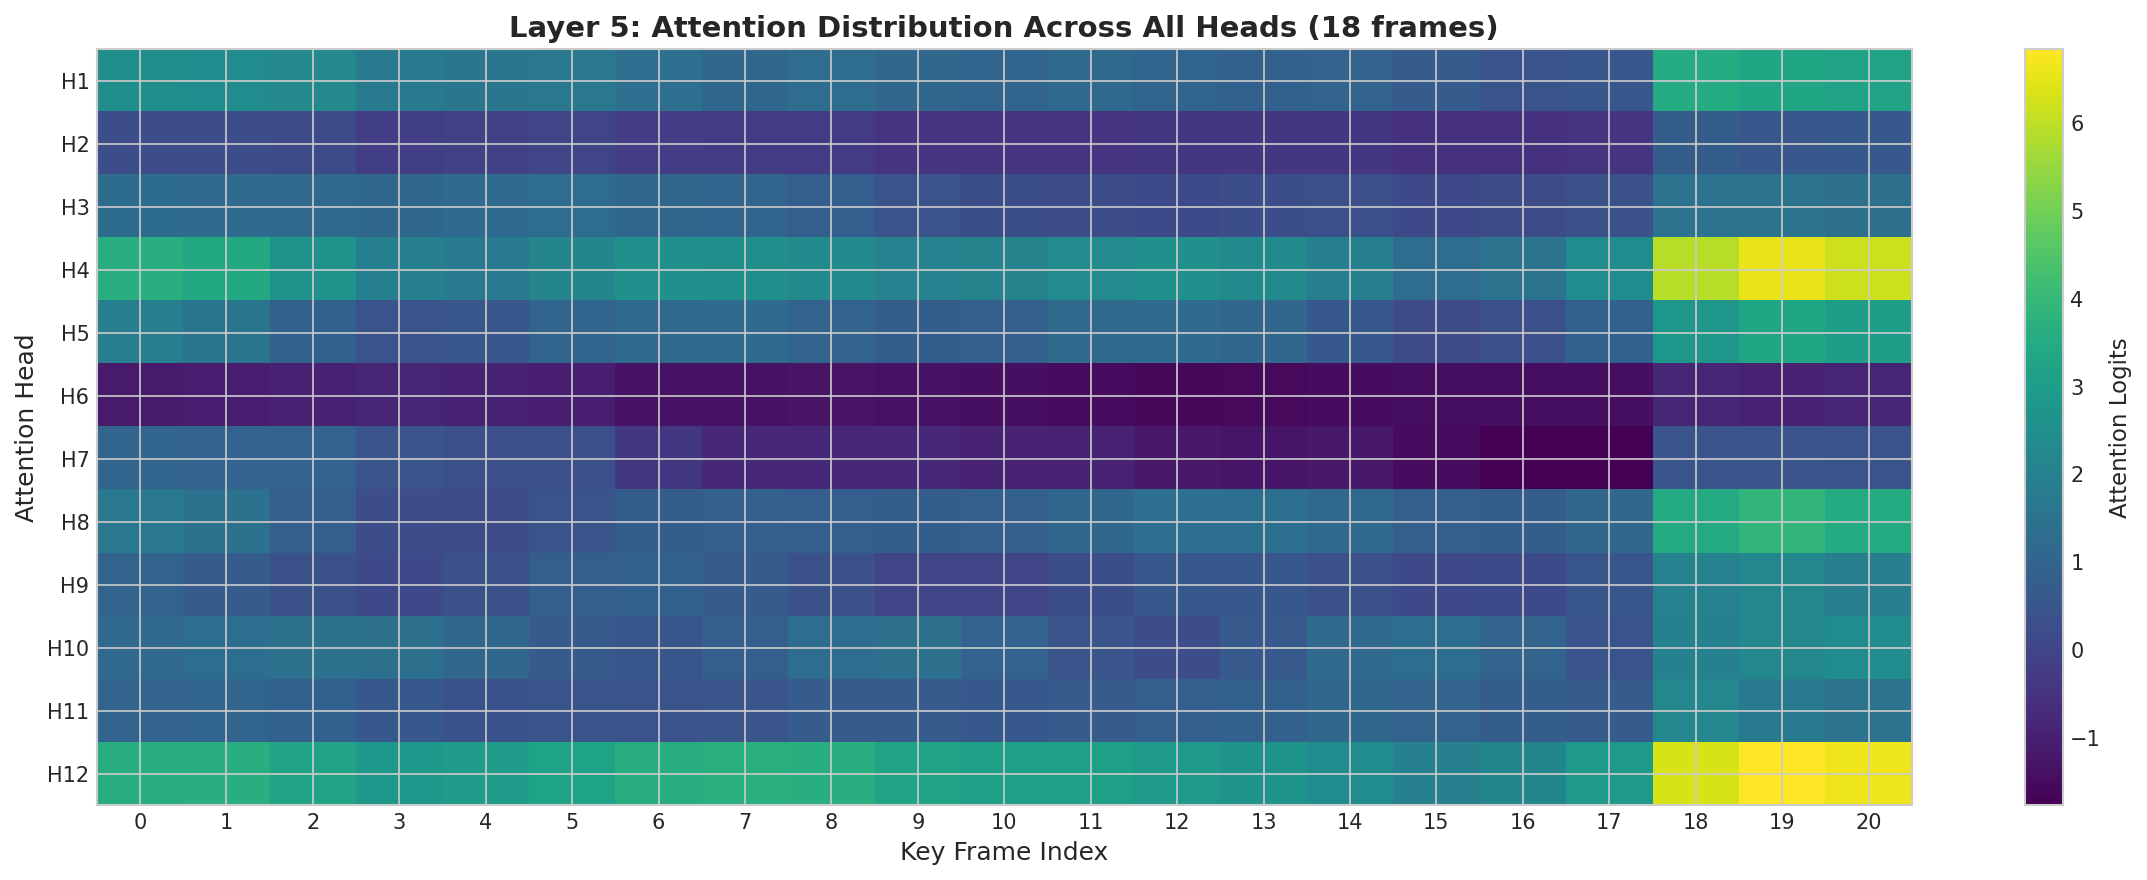

In [7]:
# ===== 绘制热力图 =====
for layer_idx in [0, 4]:
    if layer_idx not in layer_attention_data:
        continue

    frame_attn = layer_attention_data[layer_idx]["frame_attention"]
    key_indices = layer_attention_data[layer_idx]["key_frame_indices"]
    num_heads = frame_attn.shape[0]

    fig, ax = plt.subplots(figsize=(16, 6))
    im = ax.imshow(frame_attn, cmap="viridis", aspect="auto")
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Attention Logits", fontsize=11)

    ax.set_xlabel("Key Frame Index", fontsize=12)
    ax.set_ylabel("Attention Head", fontsize=12)
    ax.set_title(
        f"Layer {layer_idx+1}: Attention Distribution Across All Heads (18 frames)",
        fontsize=14,
        fontweight="bold",
    )
    ax.set_yticks(range(num_heads))
    ax.set_yticklabels([f"H{i+1}" for i in range(num_heads)])
    ax.set_xticks(range(len(key_indices)))
    ax.set_xticklabels(key_indices)

    plt.tight_layout()
    plt.savefig(
        f"figure4_layer{layer_idx+1}_all_heads.svg", format="svg", bbox_inches="tight"
    )
    print(f"已保存: figure4_layer{layer_idx+1}_all_heads.svg")
    plt.show()

已保存: figure4_layer_comparison.svg


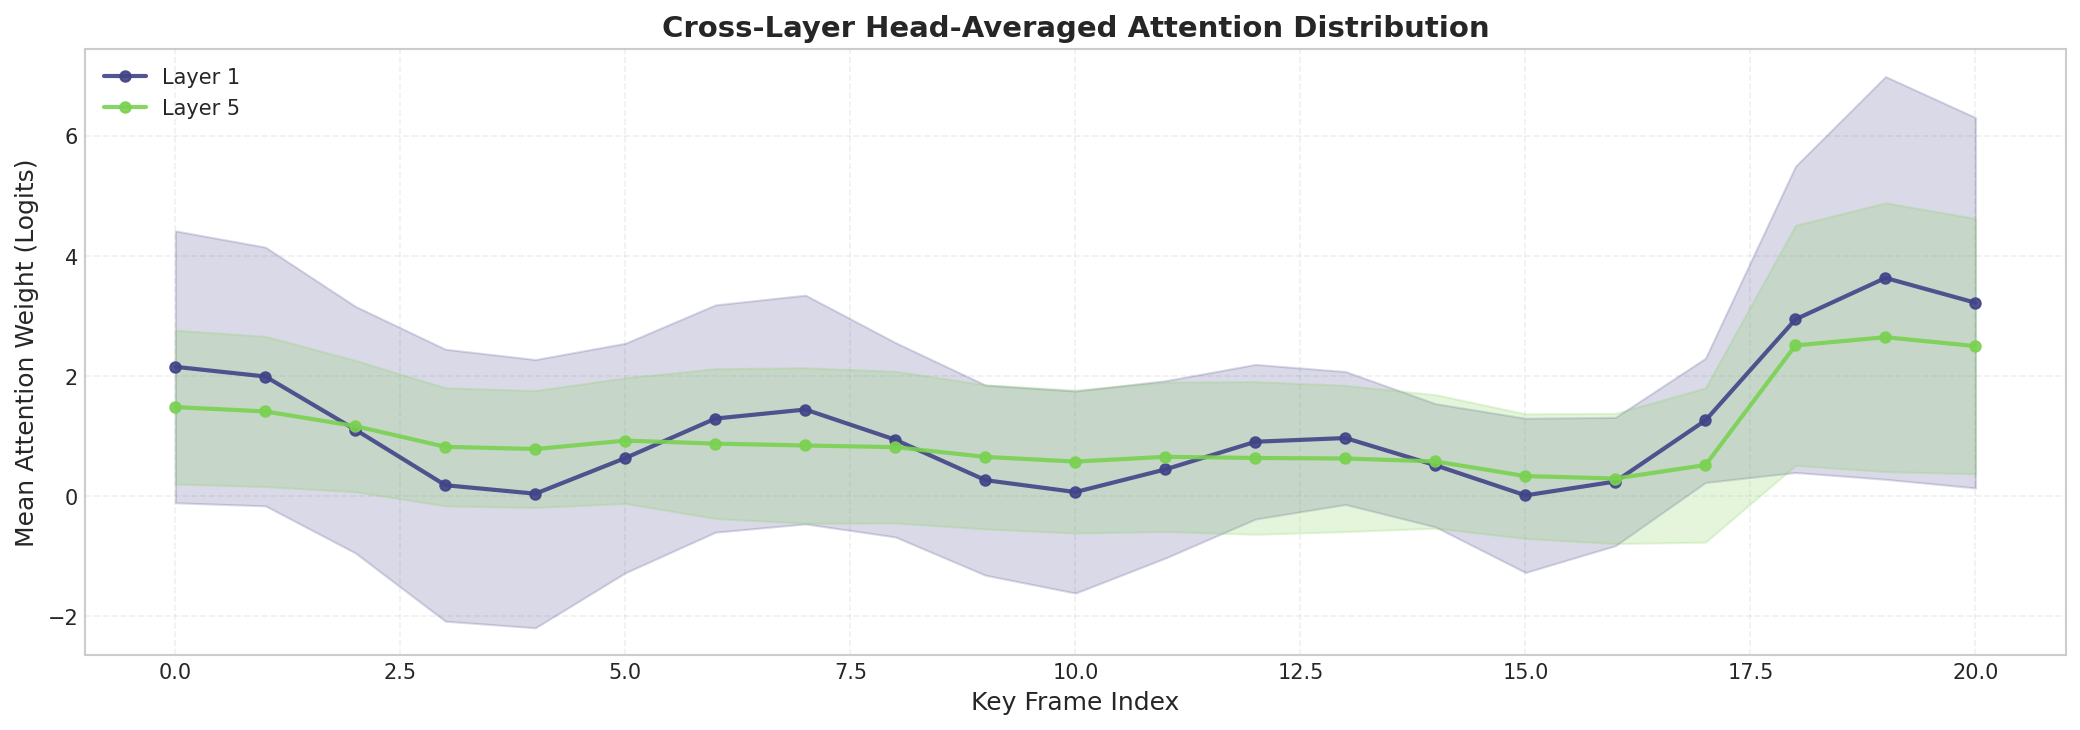

In [8]:
# ===== 跨层对比 =====
fig, ax = plt.subplots(figsize=(14, 5))
colors_cmp = plt.cm.viridis(np.linspace(0.2, 0.8, len(layer_attention_data)))

for idx, layer_idx in enumerate(sorted(layer_attention_data.keys())):
    frame_attn = layer_attention_data[layer_idx]["frame_attention"]
    key_indices = layer_attention_data[layer_idx]["key_frame_indices"]

    mean_attn = frame_attn.mean(axis=0)
    std_attn = frame_attn.std(axis=0)

    ax.plot(
        key_indices,
        mean_attn,
        "o-",
        color=colors_cmp[idx],
        linewidth=2,
        markersize=5,
        label=f"Layer {layer_idx+1}",
        alpha=0.9,
    )
    ax.fill_between(
        key_indices,
        mean_attn - std_attn,
        mean_attn + std_attn,
        color=colors_cmp[idx],
        alpha=0.2,
    )

ax.set_xlabel("Key Frame Index", fontsize=12)
ax.set_ylabel("Mean Attention Weight (Logits)", fontsize=12)
ax.set_title(
    "Cross-Layer Head-Averaged Attention Distribution", fontsize=14, fontweight="bold"
)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.savefig("figure4_layer_comparison.svg", format="svg", bbox_inches="tight")
print("已保存: figure4_layer_comparison.svg")
plt.show()

In [9]:
# ===== 统计摘要 =====
print("=" * 70)
print("统计摘要")
print("=" * 70)

for layer_idx in sorted(layer_attention_data.keys()):
    frame_attn = layer_attention_data[layer_idx]["frame_attention"]
    mean_attn = frame_attn.mean(axis=0)

    first = mean_attn[0]
    middle = mean_attn[1:-1].mean()
    last = mean_attn[-1]

    print(f"Layer {layer_idx+1}:")
    print(f"  首帧 (frame 0): {first:.4f}")
    print(f"  中间帧 (frames 1-16 avg): {middle:.4f}")
    print(f"  末帧 (frame 17): {last:.4f}")
    print(f"  首帧/中间 比值: {first/middle:.2f}x")
    print(f"  首帧 - 末帧: {first - last:.4f}")

print("=" * 70)
print("Figure 4 复现完成！")
print("=" * 70)
print("生成的 SVG 文件：")
print("  - figure4_reproduction.svg")
print("  - figure4_layer1_per_head_grid.svg")
print("  - figure4_layer5_per_head_grid.svg")
print("  - figure4_layer1_all_heads.svg")
print("  - figure4_layer5_all_heads.svg")
print("  - figure4_layer_comparison.svg")

统计摘要
Layer 1:
  首帧 (frame 0): 2.1548
  中间帧 (frames 1-16 avg): 0.9956
  末帧 (frame 17): 3.2222
  首帧/中间 比值: 2.16x
  首帧 - 末帧: -1.0673
Layer 5:
  首帧 (frame 0): 1.4844
  中间帧 (frames 1-16 avg): 0.9312
  末帧 (frame 17): 2.4996
  首帧/中间 比值: 1.59x
  首帧 - 末帧: -1.0152
Figure 4 复现完成！
生成的 SVG 文件：
  - figure4_reproduction.svg
  - figure4_layer1_per_head_grid.svg
  - figure4_layer5_per_head_grid.svg
  - figure4_layer1_all_heads.svg
  - figure4_layer5_all_heads.svg
  - figure4_layer_comparison.svg


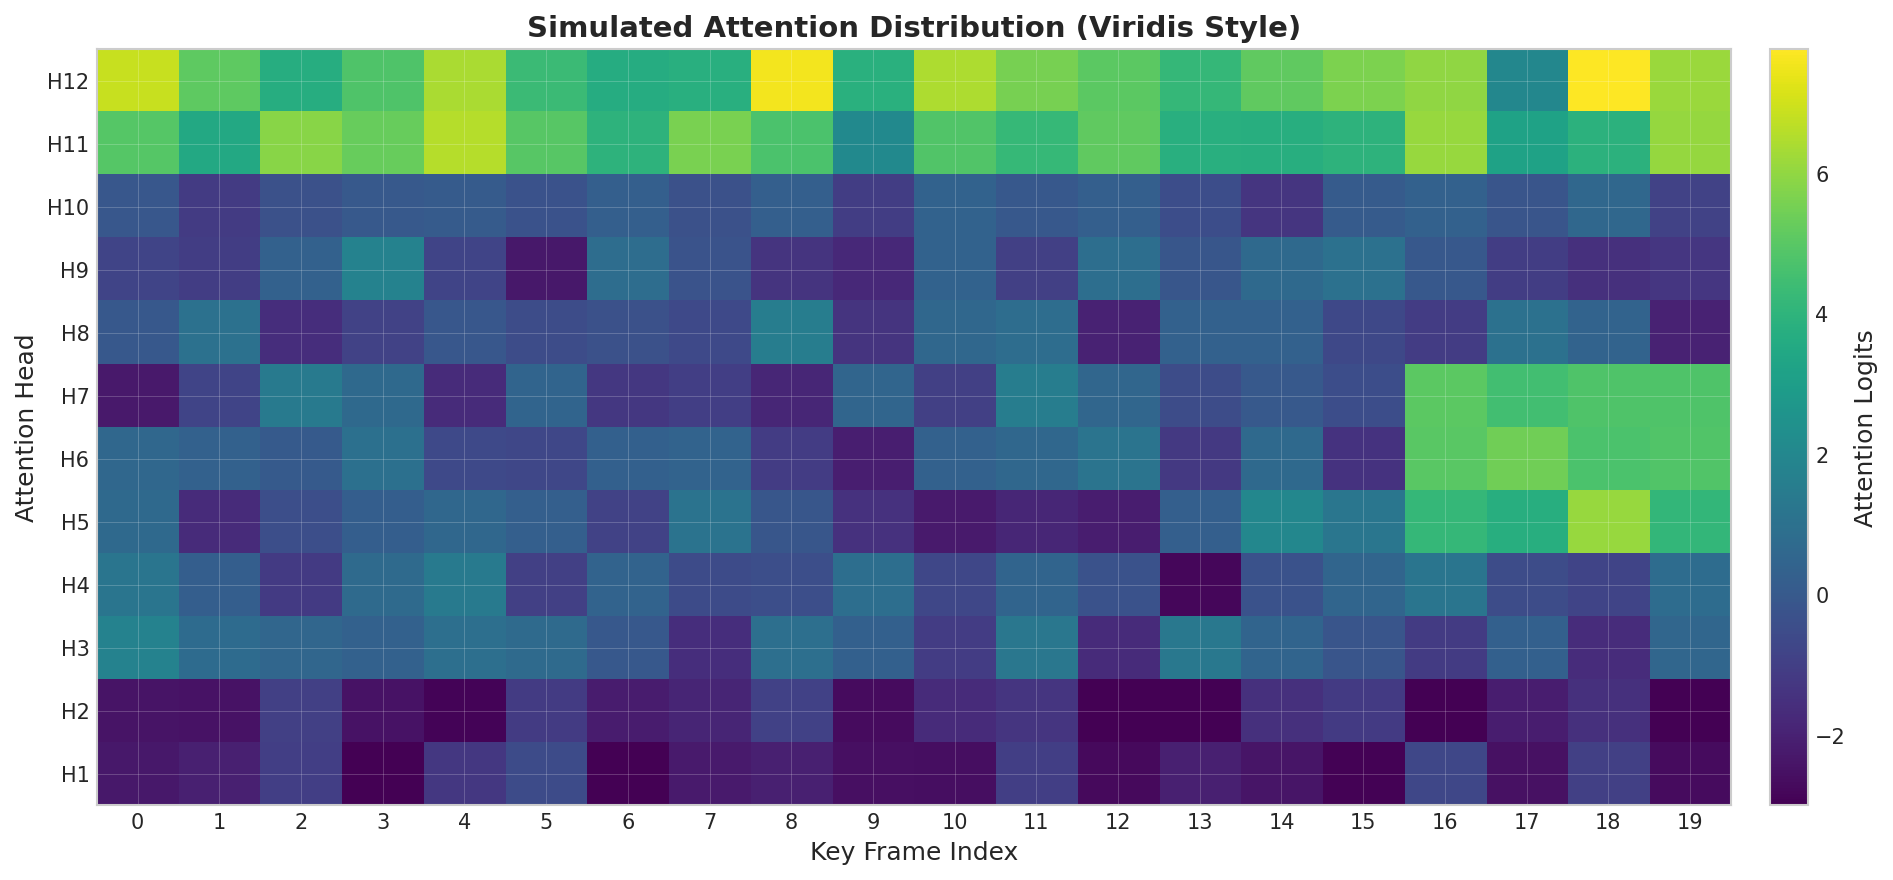

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 1. 模拟数据 (Simulate Data)
# 我们模拟一个 (Num_Heads, Seq_Len) 的矩阵
num_heads = 12
seq_len = 20

# 生成一些基础噪声数据，使用正态分布模拟 Logits
# 范围大概在 -3 到 3 之间
data = np.random.randn(num_heads, seq_len)

# 添加一些模式，让它看起来更像真实的注意力分布
# 模式 A: 活跃的 "Global Head" (比如 H11, H12)
# 它们在所有帧上的值都比较高
data[10:, :] += 4.0  # 整体抬高
data[10:, :] += np.random.rand(2, seq_len) * 2.0 # 加点随机波动

# 模式 B: 关注序列末尾的 Heads (比如 H5, H6, H7)
# 模拟它们关注最后几个 token
data[4:7, -4:] += 5.0

# 模式 C: 不活跃的 Heads (比如 H1, H2)
# 它们的值整体偏低
data[0:2, :] -= 2.0

# 将数据限制在一个合理的范围内，匹配参考图的色标范围 (-3 到 9)
data = np.clip(data, -3, 9)

# 2. 绘图 (Plotting)
fig, ax = plt.subplots(figsize=(14, 6))

# 【核心修改】使用 'viridis' 色系
# aspect='auto' 确保格子是长方形而不是被强制成正方形
# origin='lower' 确保 H1 在最下面，H12 在最上面
im = ax.imshow(data, cmap='viridis', aspect='auto', origin='lower', interpolation='nearest')

# 3. 添加装饰 (Decoration)
ax.set_title("Simulated Attention Distribution (Viridis Style)", fontsize=14, fontweight="bold")
ax.set_xlabel("Key Frame Index", fontsize=12)
ax.set_ylabel("Attention Head", fontsize=12)

# 设置 Y 轴刻度标签 (H1 到 H12)
ax.set_yticks(range(num_heads))
ax.set_yticklabels([f"H{i+1}" for i in range(num_heads)])

# 设置 X 轴刻度 (0 到 19)
ax.set_xticks(range(seq_len))

# 添加 Colorbar
cbar = plt.colorbar(im, ax=ax, pad=0.02)
cbar.set_label("Attention Logits", fontsize=12)

# 添加淡淡的网格线，增加“表格感”
ax.grid(color='w', linestyle='-', linewidth=0.5, alpha=0.2)

plt.tight_layout()
plt.show()